In [1]:
import io
import re
from difflib import ndiff
from typing import List, Tuple, Dict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyteomics import parser
from spectrum_utils import fragment_annotation, proforma
from spectrum_utils.spectrum import MsmsSpectrum

#### Initialize Util Functions

In [2]:
def _sptxt_seq_to_proforma(peptide: str, modifications: List[str]) \
        -> str:
    """
    Takes a peptide and a list of modifications to return a modified
    peptide in its ProForma format.

    Parameters
    ----------
    peptide : str
        Peptide sequence in its non-modified format.
    modifications: List[str]
        A list of modifications.

    Returns
    -------
    str
        Modified peptide in its ProForma format.
    """
    peptide = parser.parse(peptide)
    for shift, modification in enumerate(modifications):
        idx, aa, modification_name = modification.split(',')
        peptide = peptide[:int(idx) + shift + 1] + \
                  ['['+modification_name+']'] + \
                  peptide[int(idx) + shift + 1:]
    return ''.join(peptide)

In [3]:
def parse_sptxt_spectrum(identifier: int, raw_spectrum: str)\
        -> MsmsSpectrum:
    """
    Takes a raw spectrum data retrieved from an sptxt file and
    parses it to a structured object of type MsmsSpectrum.

    Parameters
    ----------
    identifier : int
        Incremented identifier of the spectrum in the library.
    raw_spectrum : string
        The spectrum in a raw format.

    Returns
    -------
    MsmsSpectrum
        An MsmsSpectrum object.
    """
    # Split raw spectrum in two chunks: metadata & spectrum
    raw_spectrum_tokens = re.split('Num\s?Peaks:\s?[0-9]+\n',
                                   raw_spectrum.strip(),
                                   flags=re.IGNORECASE)
    spectrum_metadata = raw_spectrum_tokens[0]
    spectrum = raw_spectrum_tokens[1]
    # Check if decoy
    decoy = True if re.search('decoy', spectrum_metadata,
                              re.IGNORECASE) else False
    # Retrieve peptide & charge
    peptide_Charge = spectrum_metadata.split('\n', 1)[0].split('/')
    peptide = peptide_Charge[0].split(' ')[-1].strip()
    charge = int(peptide_Charge[1].strip())
    # Retrieve precurssor mass
    precursor_mz = re.search('PrecursorMZ:\s?[0-9]+.[0-9]+', spectrum_metadata,
                      re.IGNORECASE)
    if precursor_mz:
        precursor_mz = re.search('[0-9]+.[0-9]+', precursor_mz.group(0))
    else:
        precursor_mz = re.search('Parent=\s?[0-9]+.[0-9]+', spectrum_metadata,
                          re.IGNORECASE)
        precursor_mz = re.search('[0-9]+.[0-9]+', precursor_mz.group(0))
    # Retrieve modifications
    modifications = re.search('Mods=.+?(?=[\s\n])',
                             spectrum_metadata,
                             re.IGNORECASE)
    if modifications:
        modifications = str(modifications.group(0)).split('/')[1:]
    else:
        modifications = None
    # Retrieve MZ & Intensities
    file = io.StringIO(spectrum)
    mz_intensity_annotation = pd.read_csv(file, sep="\t", header=None)

    if mz_intensity_annotation.shape[1] > 2:
        annotation = [_parse_fragment_annotation(annotation)
                      for mz, annotation in
                      zip(mz_intensity_annotation[0], mz_intensity_annotation[2])]
    else:
        annotation = [None] * len(mz_intensity_annotation[0])
    spectrum = MsmsSpectrum(str(identifier), float(precursor_mz.group(0)),
                            charge,
                            mz_intensity_annotation[0].to_numpy(copy=True),
                            mz_intensity_annotation[1].to_numpy(copy=True))

    spectrum.peptide = _sptxt_seq_to_proforma(peptide,modifications)
    spectrum.is_decoy = decoy
    spectrum._annotation = annotation

    return spectrum

In [4]:
def _shuffle(peptide_sequence: str, excluded_residues: List[str] =['K', 'R', 'P'],
             max_similarity: float = 0.7) -> Tuple[str, Dict[int, int]]:
    """
    Shuffles a peptide sequence randomly by keeping the number of tryptic
    termini and missed internal cleavages (K,R,P). The shuffled sequence has
    to be at least 70% dissimilar than the original sequence.

    Parameters
    ----------
    peptide_sequence: str
        The peptide sequence to shuffle.
    excluded_residues: List[str]
        The list of amino acids to maintain the tryptic property.

    Returns
    -------
    Tuple[str, Dict[int, int]]
        A tuple, where the first returned value is the shuffled sequence
        and the second is the mapping indecies of the shuffle.
    """
    # Parse peptide
    seq_original = parser.parse(peptide_sequence)
    # Create a list of the indices of the residuess that should not be shuffled
    indices_to_exclude = [i for i, elem in enumerate(seq_original[:-1]) if
                          elem in excluded_residues] + [len(seq_original) - 1]

    # Best permutation values
    best_similarity, best_shuffled, best_permutation = 1, '', []
    for i in range(10):
        # Shuffle the elements of original sequence, but exclude the
        # elements at the specified indices
        seq_shuffled = np.array(seq_original)
        random_permutation = np.random.permutation(
            [i for i in range(len(seq_shuffled)) if
             i not in indices_to_exclude])
        random_permutation = random_permutation.tolist()
        full_permutation = [
            random_permutation.pop(0) if i not in indices_to_exclude else i for
            i in range(len(seq_shuffled))]

        seq_shuffled = seq_shuffled[full_permutation]
        # Compute the similarity between seq_shuffled and seq_originalusing
        #  edit distance
        edit_distance = sum(
            1 for x in ndiff(seq_shuffled.tolist(), seq_original) if
            x[0] != ' ')
        similarity = 1 - (edit_distance / len(seq_original))
        # Check if similarity is below the specified threshold
        if similarity <= max_similarity:
            return ''.join(seq_shuffled), {full_permutation[i]:i  for i in
                                           range(len(seq_original))}
        elif similarity < best_similarity:
            best_similarity, best_shuffled, best_permutation = similarity, ''.join(
                seq_shuffled), full_permutation
    return best_shuffled, {full_permutation[i]:i  for i in
                           range(len(seq_original))}

In [5]:
def shuffle_and_reposition(spectrum: MsmsSpectrum) -> MsmsSpectrum:
    """
    Creates a decoy spectrum from a real spectrum.

    Parameters
    ----------
    spectrum: MsmsSpectrum
        Real spectrum.

    Returns
    -------
    MsmsSpectrum
        Decoy spectrum.
    """
    # annotate original spectrum
    spectrum.annotate_proforma(spectrum.peptide, 10, "ppm", "aby", neutral_losses=True)
    # parse original spectrum
    parsed_sequence = proforma.parse(spectrum.proforma)
    shuffled_sequence, shuffled_sequence_mapping = _shuffle(
        parsed_sequence[0].sequence)
    # Get the fragment annotations mapping dictionary
    #shuffled_annotation_mapping = _shuffle_annotation_mapping(
    #    shuffled_sequence_mapping)

    # Constract decoy proteoform
    for modification in parsed_sequence[0].modifications:
        setattr(modification, 'position',
                shuffled_sequence_mapping[modification.position])
    decoy_proforma = proforma.Proteoform(shuffled_sequence,
                                         parsed_sequence[0].modifications)
    
    
    # Get theoretical fragment M/Z of the shuffled sequence
    decoy_theoretical_fragments = {str(ion.ion_type)+'^'+str(ion.charge): mz for ion, mz in
                                   fragment_annotation.get_theoretical_fragments(
                                       decoy_proforma,ion_types="aby",max_charge=spectrum.precursor_charge)}
    
    # Reposition peaks
    mz_shuffled, intensity_shuffled, annotation_shuffled = np.zeros_like(
        spectrum.mz), np.zeros_like(spectrum.intensity), np.full_like(
        spectrum.annotation, None, object)
    for i in range(len(spectrum.mz)):
        peak_annotation = str(spectrum.annotation[i][0].ion_type)+'^'+str(spectrum.annotation[i][0].charge)
        if decoy_theoretical_fragments.get(peak_annotation) is not None:
            intensity_shuffled[i] = spectrum.intensity[i]
            mz_shuffled[i] = decoy_theoretical_fragments.get(peak_annotation)
            annotation_shuffled[i] = fragment_annotation.FragmentAnnotation(spectrum.annotation[i][0].ion_type, charge=spectrum.annotation[i][0].charge)
        else:
            intensity_shuffled[i] = spectrum.intensity[i]
            mz_shuffled[i] = spectrum.mz[i]
            annotation_shuffled[i] = None if str(spectrum.annotation[i]) == '?' else fragment_annotation.FragmentAnnotation(spectrum.annotation[i][0].ion_type, charge=spectrum.annotation[i][0].charge)
            
    # Reorder the arrays based on the sorted mz array
    reordered_arrays = zip(
        *sorted(zip(mz_shuffled, intensity_shuffled, annotation_shuffled)))
    mz_shuffled, intensity_shuffled, annotation_shuffled = map(list,
                                                               reordered_arrays)
    # Create a new `MsmsSpectrum` from the shuffled peaks
    decoy_spectrum = MsmsSpectrum("DECOY_" + spectrum.identifier,
                                  spectrum.precursor_mz,
                                  spectrum.precursor_charge, mz_shuffled,
                                  intensity_shuffled)
    decoy_spectrum.proforma = decoy_proforma
    decoy_spectrum.peptide = decoy_proforma.sequence
    decoy_spectrum._annotation = annotation_shuffled

    return decoy_spectrum

In [6]:
def plot_spectrum_peaks(x, y, annotations, peptide, title):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.3)
    width = 14
    height = width / 1.618

    plt.figure(figsize=(width, height))

    # Plot histogram of coordinates
    plt.bar(x, y, color=['#F28C28' if annotation !='' else 'b' for annotation in annotations], width=1)

    # Annotate bars
    for i, val in enumerate(annotations):
        same_coordinate_annotations = set([annotations[j] for j, coord in enumerate(x) if coord == x[i]])
        annotation_label = ', '.join(same_coordinate_annotations)
        plt.annotate(annotation_label, xy=(x[i], y[i]), xytext=(0, 5),
                     textcoords="offset points", ha='center', rotation='vertical')

    # Set the plot title and labels
    plt.title('Spectrum for peptide: '+ peptide)
    plt.xlabel('m/z')
    plt.ylabel('Intensity')

    # Show the plot
    #plt.show()
    plt.savefig(title+'_new.png', dpi=400, bbox_inches='tight')

#### Set a raw SpectraST format spectrum 

In [7]:
spectrum_exp = '''
Name: AAAAAVGNAVPCGARPCGVRPDGQPK/3
Comment: Parent=863.7635438933 Mods=3/0,A,Acetyl/11,C,Carbamidomethyl/16,C,Carbamidomethyl
Num peaks: 97
110.0712890625	270.2305183130919
129.10194396972656	505.0879485053496
143.0810546875	319.40519238407586
157.0965118408203	272.4468405812237
169.09645080566406	253.83572072462076
185.091552734375	4405.556975098193
186.0948486328125	300.4738955387689
214.11740112304688	536.348309113547
228.13368225097656	673.7400524563133
243.10874938964844	410.68842975909985
244.1651153564453	607.8662616778712
256.1283874511719	8271.020104243276
257.1318359375	864.122477242897
285.1553649902344	301.630880114089
327.16534423828125	10000.0
328.1681823730469	1778.1083360385699
342.1763000488281	337.87113174364606
398.2025451660156	6528.3492476754645
399.2055969238281	1330.5279821929842
429.2437438964844	752.8223888515713
497.2728271484375	892.8795741295298
498.27313232421875	254.98426643358437
641.3284301757812	196.37577966326313
662.3056640625	402.03595209833895
698.3411865234375	236.21902728075122
739.3699951171875	684.8673576586416
740.3728637695312	350.5226321916819
804.3751220703125	373.45311180277287
804.875244140625	324.0510482783785
812.3829345703125	454.47950704094217
812.878173828125	250.5650800894011
832.8897094726562	1294.327005287418
833.3889770507812	1238.9227680710285
833.8884887695312	628.4255798213092
834.3892211914062	349.16601443428493
917.9483642578125	521.9283262363667
918.439697265625	440.8593767147696
925.9603271484375	1119.1574168692473
926.4541625976562	1048.625851797573
926.958251953125	814.6795192121072
953.4608154296875	421.2434118450264
953.953125	297.1570211144116
954.4551391601562	241.46672232638957
954.95654296875	260.198146021856
961.4735717773438	905.2183965814768
961.9725341796875	1117.8277554906383
962.4722290039062	786.5464185003243
982.952392578125	473.55806410390056
983.4559326171875	648.9099880278483
983.9561157226562	433.88383378130516
1001.9924926757812	271.3371696499779
1010.4765014648438	294.749024595032
1010.985107421875	191.78137685695856
1018.4963989257812	1032.7904590608916
1018.9979248046875	1346.6704536779348
1019.5003051757812	929.591122446975
1019.9893188476562	547.9248739641312
1032.996337890625	458.77117051603756
1037.988037109375	364.4158458329342
1038.5008544921875	1145.1149698354122
1038.9984130859375	1186.2054499046817
1039.48291015625	443.36040073720653
1039.9923095703125	399.334634982475
1047.008056640625	6761.050787481413
1047.507568359375	7887.202224801929
1048.0052490234375	5549.569373048702
1048.50439453125	2342.96493546243
1049.0020751953125	626.9782942438644
1068.5079345703125	243.1892909234145
1068.99853515625	249.36006196671565
1087.5372314453125	238.03900279252085
1088.040283203125	430.5451622850793
1088.5277099609375	660.987565574391
1089.027587890625	349.1954904745916
1096.542724609375	3042.2799522803307
1097.0430908203125	3179.81539631892
1097.5419921875	2775.132159846175
1098.0413818359375	1151.8139899158507
1098.5423583984375	256.8999290911256
1104.0455322265625	197.4390168322348
1123.5567626953125	521.8917711470311
1124.060546875	483.6586272346518
1124.5406494140625	330.985716702761
1132.0596923828125	2438.059840793227
1132.5640869140625	2817.373525310104
1133.064208984375	1808.5066524503366
1133.554931640625	1221.6350104392377
1134.0523681640625	258.1266642964251
1159.059814453125	298.6593392989959
1159.552490234375	319.82985533655346
1160.0570068359375	285.86459809335054
1167.5792236328125	1164.269276722442
1168.077880859375	1644.1445721947496
1168.5772705078125	1133.9237532186876
1169.081298828125	577.9030068216756
1203.0899658203125	266.02756292130744
1203.58837890625	244.56762576342544
'''

In [8]:
true_spectrum = parse_sptxt_spectrum(101, spectrum_exp)
decoy_spectrum = shuffle_and_reposition(true_spectrum)

#### Reconstract the decoy sequence in proforma format string

In [9]:
peptide = parser.parse(decoy_spectrum.peptide)
modifications = {mod.position:mod.mass  for mod in decoy_spectrum.proforma.modifications}
for shift, position in enumerate(sorted(modifications.keys())):
    peptide = peptide[:position + shift + 1] + \
              ['['+str(modifications[position])+']'] + \
              peptide[position + shift + 1:]
decoy_spectrum.peptide = ''.join(peptide)

In [10]:
true_spectrum.peptide

'A[Acetyl]AAAAVGNAVPC[Carbamidomethyl]GARPC[Carbamidomethyl]GVRPDGQPK'

In [11]:
decoy_spectrum.peptide

'GC[57.021464]AGAAVAAGPGAQRPDVVRPA[42.010565]C[57.021464]NPK'

#### Plot the spectra

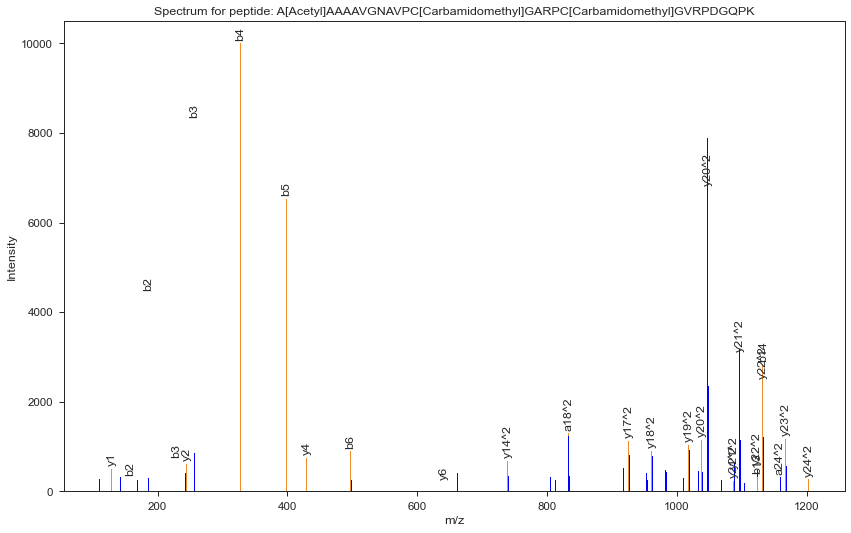

In [12]:
# Plot real spectrum .ion_type)+'^'+str(spectrum.annotation[i][0].charge)
plot_spectrum_peaks(true_spectrum.mz, 
                    true_spectrum.intensity, 
                    ['' if ant[0].ion_type =='?' else ant[0].ion_type if ant[0].charge == 1 else ant[0].ion_type+'^'+str(ant[0].charge) for ant in true_spectrum.annotation], 
                    true_spectrum.peptide,
                    'Spectrum peaks')

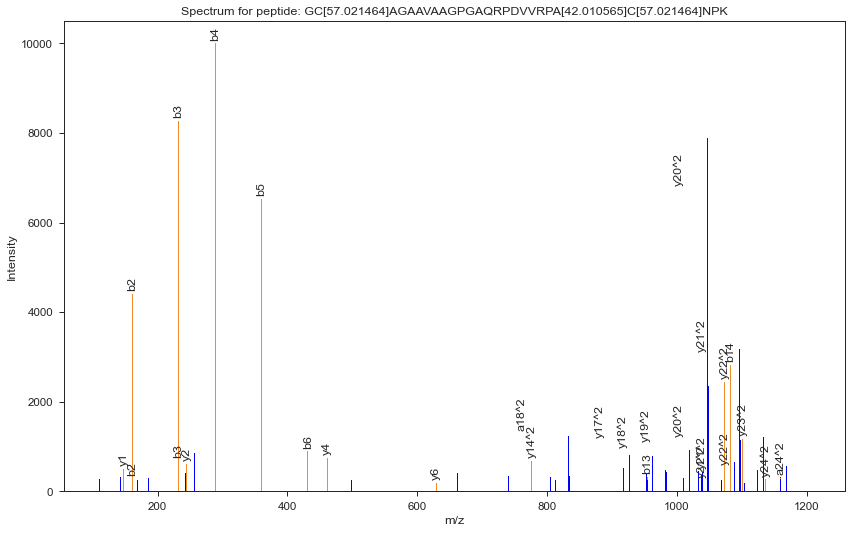

In [13]:
# Plot decoy spectrum
plot_spectrum_peaks(decoy_spectrum.mz, 
                    decoy_spectrum.intensity, 
                    ['' if ant is None  else ant.ion_type if ant.charge == 1 else ant.ion_type+'^'+str(ant.charge)  for ant in decoy_spectrum.annotation], 
                    decoy_spectrum.peptide,
                    'Decoy spectrum peaks')